Загрузим датасет и поделим на тестовую и валидационную выборки, лейблы же преобразуем в численные булевы значения по принципу принадлежности к нужному классу

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import random
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.base import BaseEstimator, ClassifierMixin


iris = load_iris()
df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                  columns=iris['feature_names'] + ['target'])

train_df = df.sample(frac=0.9)
test_df = df[~df.index.isin(train_df.index)]

X_train = train_df.drop(['target'], axis=1).values
y_train_1 = (train_df['target'] == 0).astype(int).values
y_train_2 = (train_df['target'] == 1).astype(int).values
y_train_3 = (train_df['target'] == 2).astype(int).values
X_test = test_df.drop(['target'], axis=1).values
y_test_1 = (test_df['target'] == 0).astype(int).values
y_test_2 = (test_df['target'] == 1).astype(int).values
y_test_3 = (test_df['target'] == 2).astype(int).values

Определим свой базовый классификатор для sklearn для последующих заданий

In [2]:
class LogisticRegressionClassifier(BaseEstimator, ClassifierMixin):
    def _loss(self, x):
        return 1 / (1 + np.exp(-x) + 1e-6)
    
    def _estimate_y(self, X):
        return self._loss(np.dot(X, self.theta_))
    
    def fit(self, X, y):
        pass
    
    def predict(self, X, threshold=0.5):
        return (self._estimate_y(X) >= threshold).astype(int)

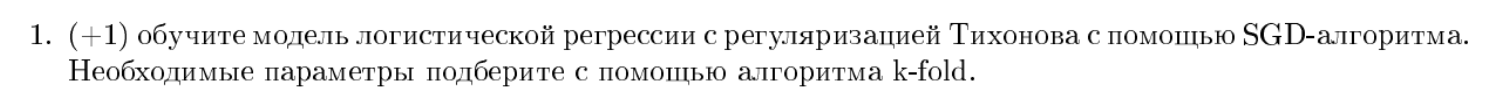

Так как в 1 и 2 заданиях требуется использовать один и тот же SGD, только с разным количеством используемых параметров, реализуем его с переменным размером батча. None в качестве размера батча будет показывать на необходимость использовать всю выборку в качестве батча (Batch SGD)

In [10]:
class LogisticRegressionSGDClassifier(LogisticRegressionClassifier):
    def __init__(self, regularization_parameter, sgd_parameter, iterations, batch_size):
        self.regularization_parameter = regularization_parameter
        self.iterations = iterations
        self.sgd_parameter = sgd_parameter
        self.batch_size = batch_size
        
    def fit(self, X, y):
        self.theta_ = np.zeros(X.shape[1])
        if self.batch_size is None:
            self.batch_size = X.shape[1]
        train_batches = [(X[i:i+self.batch_size], y[i:i+self.batch_size])
                         for i in range(0, len(X), self.batch_size)]
        for i in range(self.iterations):
            X_batch, y_batch = random.sample(train_batches, 1)[0]
            estimated = self._estimate_y(X_batch)
            regularization = 2 * self.regularization_parameter * self.theta_
            gradient = np.dot(X_batch.T, (estimated - y_batch)) / y_batch.size + regularization
            self.theta_ = self.theta_ + self.sgd_parameter * (-gradient)

Перебирая все параметры и используя 5-fold получим оптимаьные параметры, а заодно и проверим их score на валидационной выборке

In [11]:
parameters = {
    "regularization_parameter": np.linspace(1e-6, 0.1, 10),
    "sgd_parameter": np.linspace(1e-6, 0.3, 30),
}

def LogisticRegressionSGDClassifierTest(batch_size):
    logreg_sgd = LogisticRegressionSGDClassifier(0, 0, iterations=500, batch_size=batch_size)

    for i, (y_train, y_test) in \
        enumerate(zip([y_train_1, y_train_2, y_train_3], [y_test_1, y_test_2, y_test_3])):
        clf = GridSearchCV(logreg_sgd,
                           parameters,
                           scoring=make_scorer(accuracy_score),
                           n_jobs=-1)
        clf.fit(X_train, y_train)
        score = accuracy_score(clf.predict(X_test), y_test)
        print(f"For type {i} score is {score} on: {clf.best_params_}")

LogisticRegressionSGDClassifierTest(1)

For type 0 score is 1.0 on: {'regularization_parameter': 1e-06, 'sgd_parameter': 0.010345793103448275}
For type 1 score is 0.6666666666666666 on: {'regularization_parameter': 1e-06, 'sgd_parameter': 0.24827603448275862}
For type 2 score is 1.0 on: {'regularization_parameter': 1e-06, 'sgd_parameter': 0.07241455172413794}


Заметим, что алгоритм крайне старается переобучится, что можно контролировать параметром регуляризации

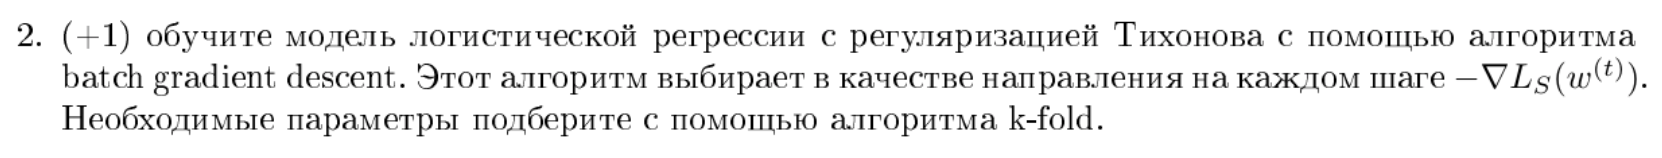

Проделаем то же самое для Batch SGD

In [14]:
LogisticRegressionSGDClassifierTest(None)

For type 0 score is 1.0 on: {'regularization_parameter': 1e-06, 'sgd_parameter': 0.010345793103448275}
For type 1 score is 0.6666666666666666 on: {'regularization_parameter': 1e-06, 'sgd_parameter': 0.20689686206896551}
For type 2 score is 1.0 on: {'regularization_parameter': 0.011112, 'sgd_parameter': 0.020690586206896552}


С одной стороны, Batch SGD сходится быстрее, так как учитывает всю выборку, а не ходит по каждой координате, с другой, матричные операции имеют большую ассимптотическую сложность, что приведет к крайне высокому времени работы. Кажется, что в имеющейся реализации можно выбирать оптимальный размер батча как конфигурируемый параметр не только из его крайних значений. При этом путь при батче = 1 у алгоритма намного более ломаный и случайный, а с повышением его размера становится более направленным к истинному минимуму?